<a href="https://colab.research.google.com/github/DCI-alxogm/ml2023-JuanLeonelSantamariaMena/blob/main/Nov11/EjercicioNov11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import glob
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline

#Capas

$$a_j^{[l]}=g(\vec{w}_j^{[l]}\cdot \vec{a}^{[l-1]}+b^{[l]})$$

# Carga de textos

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#Los datos corresponden a un subset del dataset cats vs dogs de https://www.kaggle.com/c/dogs-vs-cats
files=glob.glob('/content/drive/MyDrive/UGTO/DCI-data/CATS_DOGS/*')
len(files)

Mounted at /content/drive


1787

# Conjunto de datos(Preparación)

In [3]:
#numero de pixeles para nuestras imágenes.
num_px=64

train_x=[]
train_y=[]
test_x=[]
test_y=[]
i,j=0,0
for file in files[:]:
    img=Image.open(file)
    img=img.resize((num_px,num_px))
    data=np.asarray(img)
    if 'dog' in file and i<100:
        if i<50:
          train_y.append(1)
          train_x.append(data)
        if i>49:
          test_y.append(1)
          test_x.append(data)
        i +=1
        img.close()
    if 'cat' in file and j<100:
        if j<50:
          train_y.append(0)
          train_x.append(data)
        if j>49:
          test_y.append(0)
          test_x.append(data)
        j +=1
        img.close()
    if i==100 and j==100:
        print(f'100/100:{i}/{j}')
        break
        img.close()
train_y=np.asarray(train_y)
train_x=np.asarray(train_x)
test_y=np.asarray(test_y)
test_x=np.asarray(test_x)


100/100:100/100


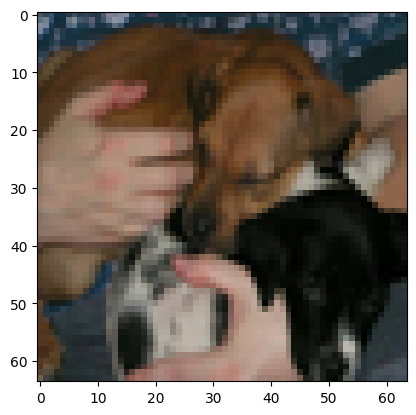

In [4]:
plt.imshow(train_x[50])

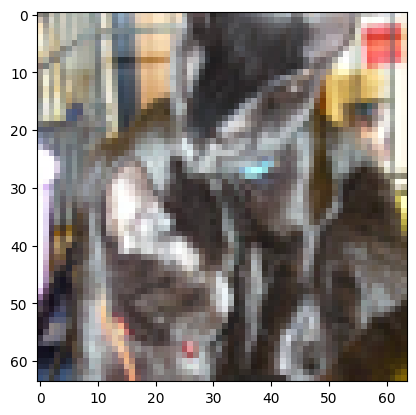

In [5]:
plt.imshow(test_x[0])

In [6]:
train_x_flatten = train_x.reshape(train_x.shape[0], -1).T

test_x_flatten = test_x.reshape(test_x.shape[0], -1).T

train_set_y=train_y.reshape((1,train_y.shape[0]))
test_set_y=test_y.reshape((1,test_y.shape[0]))

train_set_x= train_x_flatten/255
test_set_x= test_x_flatten/255

#funciones

funciones usadas en la implementacion de una sola neurona  de las cueles se utilizaran y modificaran z, g, costo

In [7]:
#funcion Z
def z(x,w,b):
  return w.T @ x + b
#funcion g sigmoide
def g(x,w,b,z):
  return (1/(1+np.exp(-z(x,w,b))))
#funcion costo
def J(x,y,w,b,z,g):
  y_=g(x,w,b,z)
  m=y.shape[1]
  j=np.sum(y*np.log(y_)+(1-y)*np.log(1-y_))
  return -j/m


#derivada
def dw(x,y,w,b,z,g):
  y_=g(x,w,b,z)
  m=y.shape[1]
  return (1/m)*x@(y_-y)

def db(x,y,w,b,z,g):
  y_=g(x,w,b,z)
  m=y.shape[1]
  return (1/m)*(y_-y)

def Grad_desc(x,y,w,b,z,g,iter=1000,alpha=0.001):
  costs=[]
  for i in range(iter):
    # Registro de costo
    j=J(x,y,w,b,z,g)
    costs.append(j)
    # Actualizacion de pesos
    w=w-alpha*dw(x,y,w,b,z,g)
    b=b-alpha*db(x,y,w,b,z,g)
    if (i%10==0 ):
      print(f'Iteracion:{i},     costo:{j},    w:{np.sum(w)},   b:{np.sum(b)}')

  return costs,w,b

intneto de la implementacion de la propagacion con su respectivo backward

In [19]:

def Neurona(x,y,capas,neuronas,z,g,iter=1000,alpha=0.001):
  # capas
  a=x
  #print(a.shape)
  for c in range(capas):
    a_new=[]
    costs=[]
    for n in range(neuronas[c]):
      w=0.1*np.random.random(size=list(a.shape))
      b=0.1*np.random.random(size=a.shape[1])
      j_temp=[]
      for i in range(iter):
        # Registro de costo
        j=J(x,y,w,b,z,g)
        j_temp.append(j)
        # Actualizacion de pesos
        w=w-alpha*dw(x,y,w,b,z,g)
        b=b-alpha*db(x,y,w,b,z,g)
      a_new.append(g(a,w,b,z))
    a=a_new
    costs.append(j_temp)
    if (n%10==0 ):
      print(f'neurono{c,n+1},     costo:{j},    w:{np.sum(w)},   b:{np.sum(b)}')

  return costs,w,b

## Propagacion 3 neuronas

In [17]:
def forward(x,y,capas,neuronas,z,g,iter=1000,alpha=0.001):
  # capas
  a=x
  print(a.shape)
  for c in range(capas):
    a_new=[]
    for n in range(neuronas[c]):
      w=0.001*np.random.random(size=a.shape)
      b=0.001*np.random.random(size=a.shape)
      #j=J(a,y,w,b,z,g)
      a_new.append(np.sum(w * a + b))     #relacion del producto punto np.sum(A*B)
      print(f'neurono{c,n+1},    costo:{j},    activacion:{np.sum(a)},    w:{np.sum(w)},   b:{np.sum(b)}')
    a=np.array(a_new)
  return w,b

#parametros

In [10]:
#parametros iniciales
w=np.zeros(train_set_x.shape)
b=np.zeros(train_set_y.shape[1])
# Parametro de aprendizaje
alpha= 0.02
w.shape
#costos ,w_ ,b_ =Grad_desc(train_set_x,train_set_y,w,b,z,g,iter=100,alpha=0.00001)

(12288, 100)

In [11]:
np.random.seed(1235)
#Parametros
capas=2         #numero l-1
neuronas=[2,1]

In [21]:
w,b=forward(train_set_x,train_set_y,capas,neuronas,z,g,iter=100,alpha=0.0001)

(12288, 100)
neurono(0, 1),    costo:100,    activacion:559412.5490196078,    w:614.3435343243434,   b:614.723186814139
neurono(0, 2),    costo:100,    activacion:559412.5490196078,    w:614.5015595199529,   b:614.5242188470195
neurono(1, 1),    costo:100,    activacion:1788.503409149485,    w:0.0010194742688800224,   b:0.0009151833249344977
